In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('dataset.csv')
print("Dataset loaded successfully.")
display(df.head())

Dataset loaded successfully.


,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
0,2009-12-31,10428.049805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.03,0.26,-1.08,-1.00,-0.11,-0.08,-0.06,-0.48,0.30,0.39
1,2010-01-04,10583.959961,NaN,0.014951,NaN,NaN,NaN,NaN,NaN,NaN,...,1.52,3.26,1.61,1.62,-0.57,-0.59,-0.42,3.12,3.91,2.10
2,2010-01-05,10572.019531,NaN,-0.001128,0.014951,NaN,NaN,NaN,NaN,NaN,...,-0.07,1.96,-0.20,0.31,0.43,0.03,0.12,-0.90,1.42,-0.12
3,2010-01-06,10573.679688,0.515598,0.000157,-0.001128,0.014951,NaN,NaN,NaN,NaN,...,0.56,2.15,-0.02,0.07,-0.56,-0.24,-0.17,2.62,2.25,1.77
4,2010-01-07,10606.860352,9.776045,0.003138,0.000157,-0.001128,0.014951,NaN,NaN,NaN,...,-0.72,0.94,0.50,0.40,0.58,0.58,0.54,-1.85,0.22,-0.58


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
print('Missing values before handling:')
print(df.isnull().sum().sort_values(ascending=False).head())
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
print('\nMissing values after handling:')
print(df.isnull().sum().sum())
df.drop_duplicates(inplace=True)
print(f'\nNumber of duplicate rows: {df.duplicated().sum()}')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

Missing values before handling:
CAD     2415
JPY     2395
CNY     2395
GBP     2390
SSEC    1190
dtype: int64

Missing values after handling:
0

Number of duplicate rows: 0


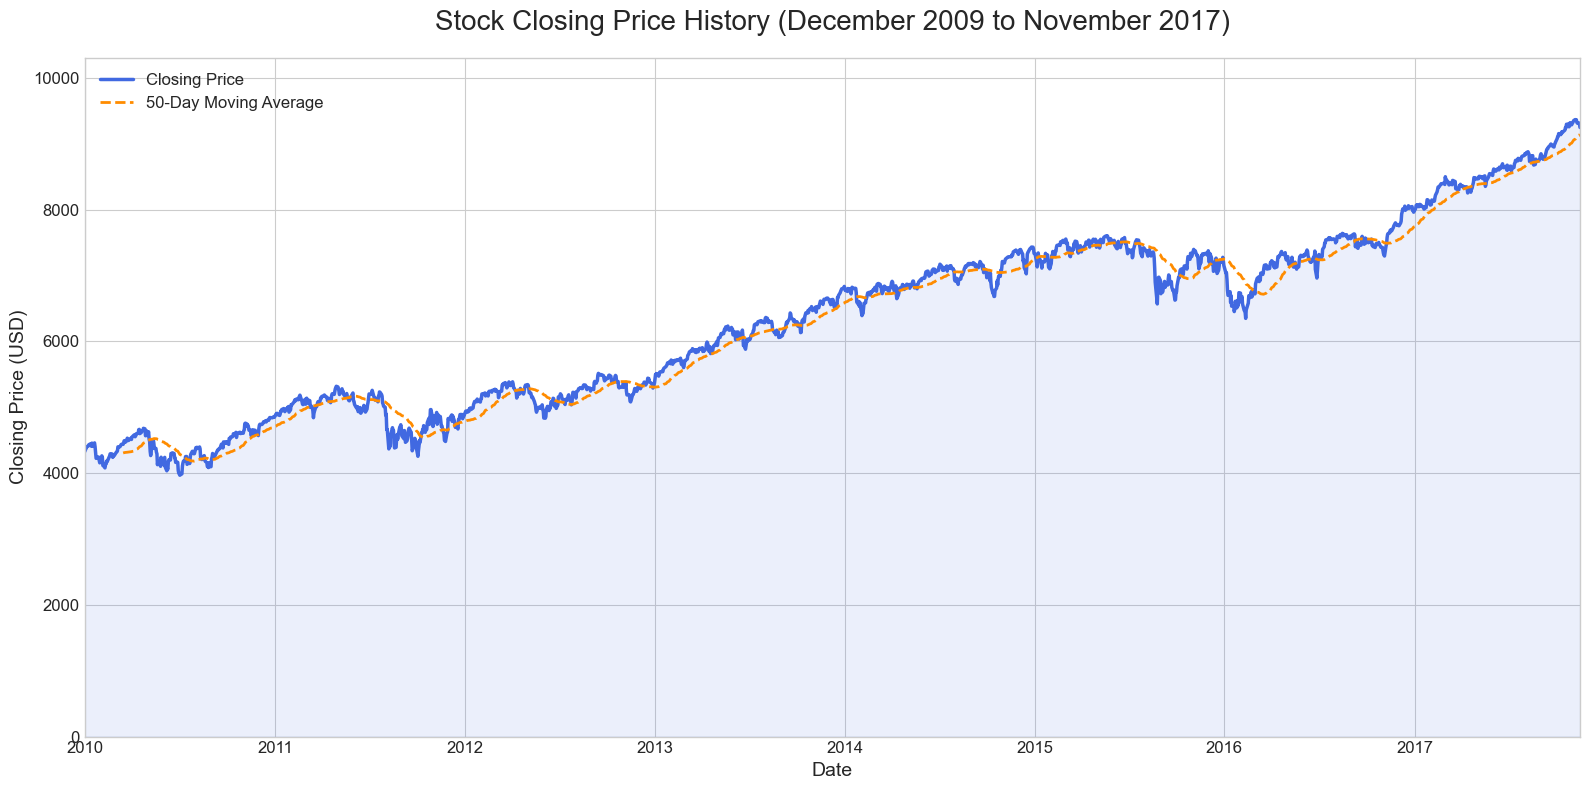

In [39]:
numeric_cols = df.select_dtypes(include=np.number)
df['SMA_50'] = df['Close'].rolling(window=50).mean()
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(data=df, x=df.index, y='Close',
             label='Closing Price',
             color='royalblue',
             linewidth=2.5,
             ax=ax)
sns.lineplot(data=df, x=df.index, y='SMA_50',
             label='50-Day Moving Average',
             color='darkorange',
             linestyle='--',
             linewidth=2,
             ax=ax)
ax.fill_between(df.index, df['Close'],
                color='royalblue',
                alpha=0.1)
start_date = df.index.min().strftime('%B %Y')
end_date = df.index.max().strftime('%B %Y')
ax.set_title(f'Stock Closing Price History ({start_date} to {end_date})', fontsize=20, pad=20)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Closing Price (USD)', fontsize=14)
ax.legend(fontsize=12, loc='upper left')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([df.index.min(), df.index.max()])
ax.set_ylim([0, df['Close'].max() * 1.1])
plt.tight_layout()
plt.show()

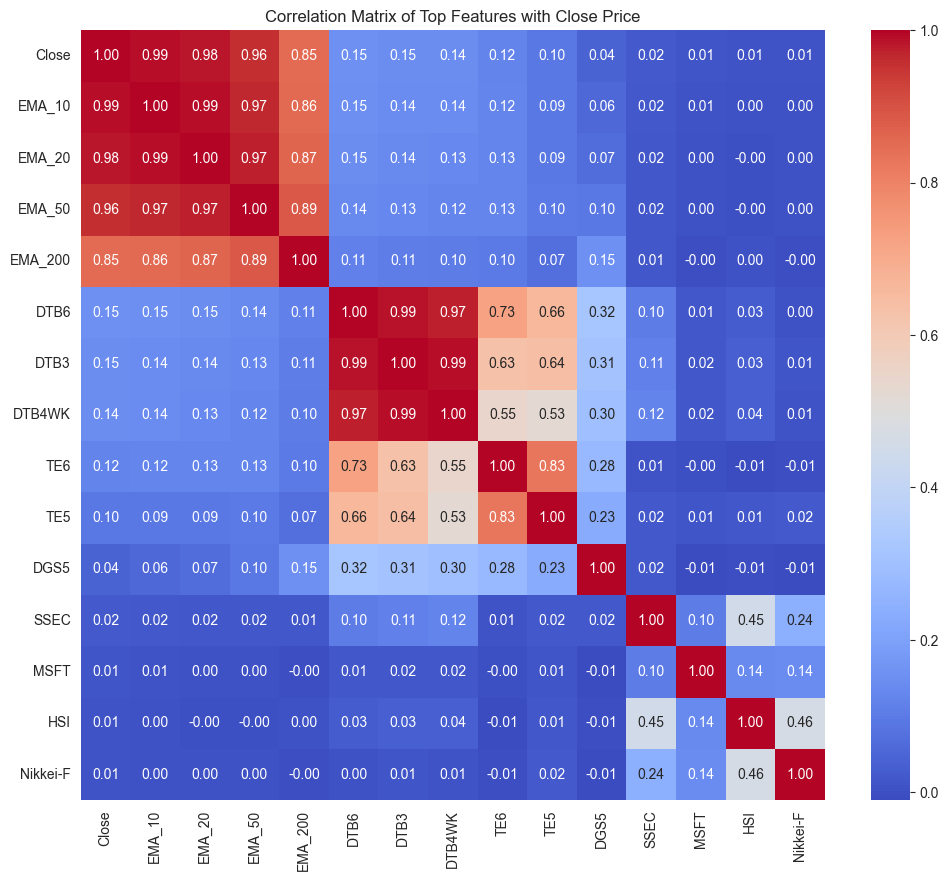

In [5]:
df_numeric = df.select_dtypes(include=np.number)
corr_matrix = df_numeric.corr()
top_corr_features = corr_matrix.nlargest(15, 'Close')['Close'].index
top_corr_matrix = df_numeric[top_corr_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top Features with Close Price')
plt.show()

In [6]:
y = df['Close']
X = df.drop(['Close', 'Name'], axis=1, errors='ignore')

In [7]:
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 7936 samples
Test set size: 1984 samples


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [9]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=42, n_jobs=-1)
}

In [10]:
results = {}
predictions = {}

for name, model in models.items():
    print(f'--- Training {name} ---')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {'R2': r2, 'MAE': mae, 'RMSE': rmse}
    print(f'R2 Score: {r2:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}\n')

results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
print('--- Model Comparison ---')
display(results_df)

--- Training Linear Regression ---
R2 Score: 0.9934
MAE: 480.8195
RMSE: 564.8167

--- Training Decision Tree ---
R2 Score: 0.9717
MAE: 496.2403
RMSE: 1169.8286

--- Training Random Forest ---
R2 Score: 0.9572
MAE: 615.4366
RMSE: 1440.2756

--- Training Gradient Boosting ---
R2 Score: 0.8110
MAE: 1010.8423
RMSE: 3025.3525

--- Training XGBoost ---
R2 Score: 0.9645
MAE: 546.6439
RMSE: 1310.5342

--- Training LightGBM ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18884
[LightGBM] [Info] Number of data points in the train set: 7936, number of used features: 81
[LightGBM] [Info] Start training from score 5875.976484
R2 Score: 0.9381
MAE: 701.8249
RMSE: 1730.8752

--- Model Comparison ---


,R2,MAE,RMSE
Linear Regression,0.993411,480.819479,564.816697
Decision Tree,0.971735,496.240291,1169.828621
XGBoost,0.964527,546.643885,1310.534245
Random Forest,0.957156,615.436646,1440.275650
LightGBM,0.938122,701.824920,1730.875168
Gradient Boosting,0.810960,1010.842326,3025.352458


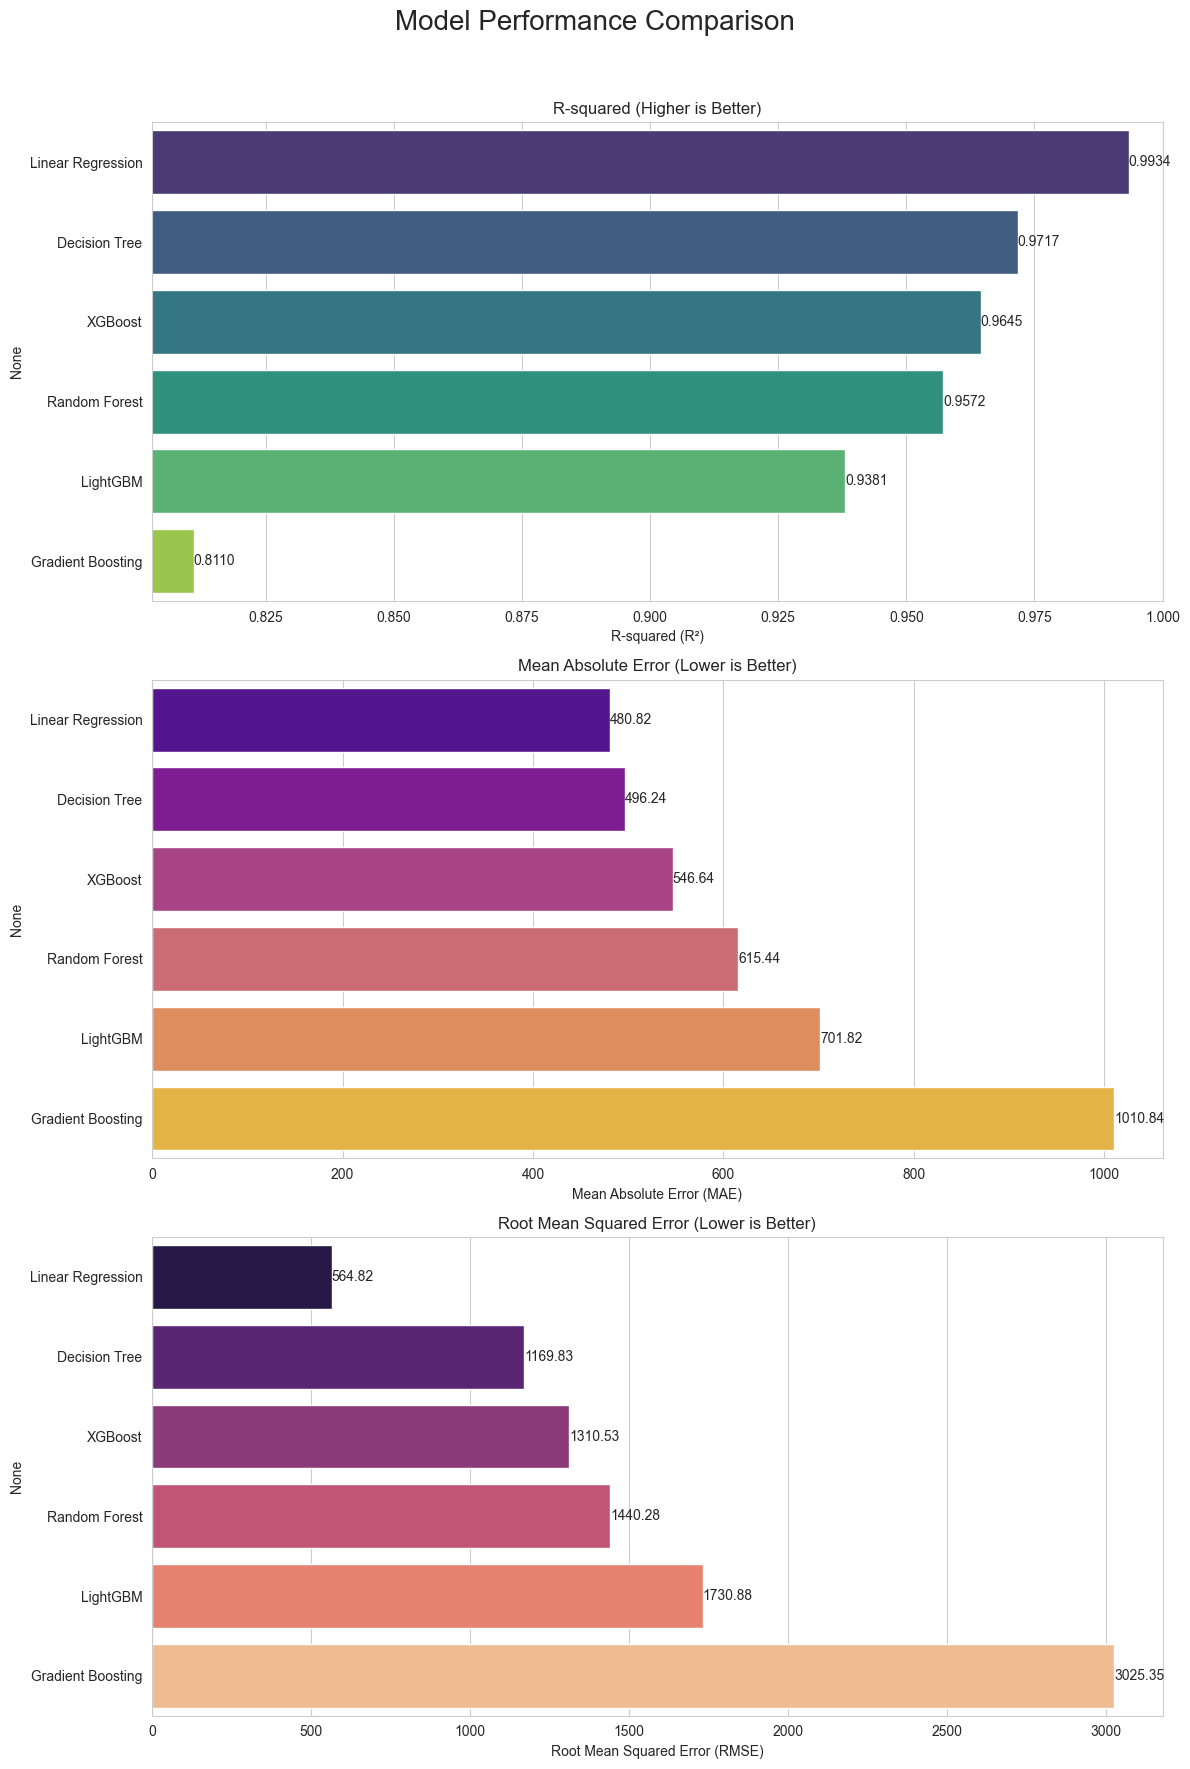

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
fig.suptitle('Model Performance Comparison', fontsize=20)

r2_sorted = results_df.sort_values(by='R2', ascending=False)
sns.barplot(x=r2_sorted['R2'], y=r2_sorted.index, ax=axes[0], palette='viridis')
axes[0].set_xlabel('R-squared (R²)')
axes[0].set_title('R-squared (Higher is Better)')
axes[0].set_xlim([r2_sorted['R2'].min() * 0.99, 1.0])
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.4f')

mae_sorted = results_df.sort_values(by='MAE', ascending=True)
sns.barplot(x=mae_sorted['MAE'], y=mae_sorted.index, ax=axes[1], palette='plasma')
axes[1].set_xlabel('Mean Absolute Error (MAE)')
axes[1].set_title('Mean Absolute Error (Lower is Better)')
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f')

rmse_sorted = results_df.sort_values(by='RMSE', ascending=True)
sns.barplot(x=rmse_sorted['RMSE'], y=rmse_sorted.index, ax=axes[2], palette='magma')
axes[2].set_xlabel('Root Mean Squared Error (RMSE)')
axes[2].set_title('Root Mean Squared Error (Lower is Better)')
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%.2f')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
